In [1]:
from shapely import Point, Polygon, LineString, MultiPoint
from shapely.plotting import plot_polygon, _path_from_polygon
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from matplotlib.quiver import Quiver
from matplotlib.artist import Artist

from matplotlib import animation
import numpy as np
from matplotlib.axes import Axes
from typing import TypeAlias
from tqdm import tqdm

In [2]:
RealNumber: TypeAlias = int | float

In [3]:
class Robot:
    def __init__(
        self,
        x: RealNumber,
        y: RealNumber,
        theta: float,
        radius: RealNumber,
        max_distance: RealNumber,
    ) -> None:
        self.theta = theta
        self.center_pos = [x, y]
        self.radius = radius
        self.max_distance = max_distance

    def get_shape(self) -> Polygon:
        x, y = self.center_pos
        return Point(x, y).buffer(self.radius)

    def get_direction(self) -> tuple[float, float, float, float]:
        x, y = self.center_pos
        dx = self.radius * np.cos(self.theta)
        dy = self.radius * np.sin(self.theta)
        return x + dx, y + dy, 4 * dx, 4 * dy

    def visualize(
        self, ax: Axes = None, alpha: float = 1.0, color: str = "blue"
    ) -> list[PathPatch, Quiver]:
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_aspect("equal")

        polygon_path_patch = plot_polygon(
            self.get_shape(),
            ax=ax,
            color=color,
            add_points=False,
            alpha=alpha,
            edgecolor="black",
            linewidth=0,
        )

        arrow = ax.quiver(
            *self.get_direction(),
            angles="xy",
            scale_units="xy",
            scale=1,
            width=0.003,
            color=color,
            alpha=alpha,
        )

        return [polygon_path_patch, arrow]

    def measure_distance(self, world: Polygon) -> float:
        robot_shape = self.get_shape()
        ray = LineString(
            [
                self.center_pos,
                (
                    self.center_pos[0] + self.max_distance * np.cos(self.theta),
                    self.center_pos[1] + self.max_distance * np.sin(self.theta),
                ),
            ]
        )
        intersection = ray.intersection(world.boundary, grid_size=0.1)

        if intersection.is_empty:
            distance = self.max_distance
        else:
            # if multiple intersections
            # after test, shapely returns the closest one
            distance = robot_shape.distance(intersection)

        return distance

    def move(
        self, v: float, w: float, dt: float, v_sigma: float, w_sigma: float
    ) -> None:
        """
        Move the robot with linear velocity v and angular velocity w
        for a small time dt. Update the robot's position and orientation.

        Args:
            v (float): Linear velocity.
            w (float): Angular velocity.
            dt (float): Time step.
        """
        x, y = self.center_pos
        v = np.random.normal(v, v_sigma)

        if w < 1e-5:
            # if w is small, don't add noise
            new_x = x + v * np.cos(self.theta) * dt
            new_y = y + v * np.sin(self.theta) * dt
        else:
            w = np.random.normal(w, w_sigma)
            new_x = x + v / w * (np.sin(self.theta + w * dt) - np.sin(self.theta))
            new_y = y - v / w * (np.cos(self.theta + w * dt) - np.cos(self.theta))
            self.theta = (self.theta + w * dt) % (2 * np.pi)

        self.center_pos = [new_x, new_y]

    def update_artist(self, artists: list) -> None:
        polygon, arrow = artists
        polygon: PathPatch
        polygon.set_path(_path_from_polygon(self.get_shape()))
        x, y, dx, dy = self.get_direction()
        arrow.set_offsets([x, y])
        arrow.set_UVC(dx, dy)


class SampleParticle(Robot):
    def __init__(
        self,
        x: RealNumber,
        y: RealNumber,
        theta: float,
        radius: RealNumber,
        weight: float = 1.0,
    ) -> None:
        super().__init__(x, y, theta, radius)
        self.weight = weight

    def update_weight(self, factor: float) -> None:
        self.weight = factor

    def visualize(self, ax=None, color="blue"):
        return super().visualize(ax, self.weight, color)

    def update_artist(self, artists: list) -> None:
        polygon_path_patch, arrow = artists
        polygon_path_patch: PathPatch
        polygon_path_patch.set_path(_path_from_polygon(self.get_shape()))
        polygon_path_patch.set_alpha(self.weight)
        x, y, dx, dy = self.get_direction()
        arrow.set_offsets([x, y])
        arrow.set_UVC(dx, dy)
        arrow.set_alpha(self.weight)


class ParticleGroup:
    def __init__(
        self,
        positions: np.ndarray,
        thetas: np.ndarray,
        weights: np.ndarray,
        radius: RealNumber,
        max_distance: RealNumber,
    ) -> None:
        self.num_particles = len(positions)
        self.positions = positions
        self.thetas = thetas
        self.weights = weights
        self.radius = radius
        self.max_distance = max_distance

    def measure_distance(self, world: Polygon) -> np.ndarray:
        distances = np.zeros(self.num_particles)
        for i, ((x, y), theta) in enumerate(zip(self.positions, self.thetas)):
            robot = Robot(
                x, y, theta, radius=self.radius, max_distance=self.max_distance
            )
            distances[i] = robot.measure_distance(world)

        return distances

    def update_weights(self, weights: np.ndarray) -> None:
        self.weights = weights

    def resample(
        self,
        lvr_idx: np.ndarray,
        random_positions: np.ndarray,
        random_thetas: np.ndarray,
    ) -> None:
        self.positions = np.concatenate(
            [
                self.positions[lvr_idx],
                random_positions,
            ]
        )
        self.thetas = np.concatenate(
            [
                self.thetas[lvr_idx],
                random_thetas,
            ]
        )
        self.weights = np.ones(len(self.positions)) / len(self.positions)

    def move(
        self, v: float, w: float, dt: float, v_sigma: float, w_sigma: float
    ) -> None:
        v = np.random.normal(v, v_sigma, self.num_particles)
        if w < 1e-5:
            self.positions[:, 0] += v * np.cos(self.thetas) * dt
            self.positions[:, 1] += v * np.sin(self.thetas) * dt
        else:
            w = np.random.normal(w, w_sigma, self.num_particles)
            self.positions[:, 0] += (
                v / w * (np.sin(self.thetas + w * dt) - np.sin(self.thetas))
            )
            self.positions[:, 1] -= (
                v / w * (np.cos(self.thetas + w * dt) - np.cos(self.thetas))
            )
            self.thetas = (self.thetas + w * dt) % (2 * np.pi)

    def visualize(
        self, ax: Axes = None, color: str = "red"
    ) -> list[list[PathPatch], Quiver]:
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_aspect("equal")

        # polygon_path_patch = plot_polygon(
        #     self.get_shape(),
        #     ax=ax,
        #     color=color,
        #     add_points=False,
        #     alpha=self.weights,
        #     edgecolor="black",
        #     linewidth=0,
        # )

        # create a polygon for each particle to set alpha
        polygon_path_patch = [
            plot_polygon(
                Polygon(self.get_shape(i)),
                ax=ax,
                color=color,
                add_points=False,
                alpha=self.weights[i],
                edgecolor="black",
                linewidth=0,
            )
            for i in range(self.num_particles)
        ]

        arrows = ax.quiver(
            *self.get_direction(),
            angles="xy",
            scale_units="xy",
            scale=1,
            width=0.003,
            color=color,
            alpha=self.weights,
        )

        return [polygon_path_patch, arrows]

    def get_shape(self, idx: int) -> Polygon:
        return Point(self.positions[idx, 0], self.positions[idx, 1]).buffer(self.radius)

    def get_direction(self) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        dx = self.radius * np.cos(self.thetas)
        dy = self.radius * np.sin(self.thetas)
        return (
            self.positions[:, 0] + dx,
            self.positions[:, 1] + dy,
            4 * dx,
            4 * dy,
        )

    def update_artist(self, artists: list) -> None:
        polygon_path_patches, arrows = artists[:-1], artists[-1]
        polygon_path_patches: list[PathPatch]
        arrows: Quiver

        for i in range(self.num_particles):
            polygon_path_patches[i].set_path(_path_from_polygon(self.get_shape(i)))
            polygon_path_patches[i].set_alpha(np.maximum(self.weights[i], 0.1))

        x, y, dx, dy = self.get_direction()
        arrows.set_offsets(np.column_stack([x, y]))
        arrows.set_UVC(dx, dy)
        arrows.set_alpha(np.maximum(self.weights, 0.1))

In [4]:
class Map:
    def __init__(self, boundary: list[tuple], obstacles: list[list[tuple]]) -> None:
        self.world = Polygon(boundary, holes=obstacles)

    def visualize(self, ax=None) -> None:
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_aspect("equal")
        plot_polygon(self.world, ax=ax, add_points=False, color="gray", alpha=0.4)

    def sample_points(self, n: int, robot_radius: RealNumber) -> list[tuple]:
        """
        Sample n points in the world, avoiding obstacles.

        Returns:
            list[tuple]: List of (x, y) coordinates of the sampled points.
        """
        min_x, min_y, max_x, max_y = self.world.bounds
        points = []
        while len(points) < n:
            x = np.random.uniform(min_x, max_x)
            y = np.random.uniform(min_y, max_y)
            point = Point(x, y).buffer(robot_radius)
            if self.world.contains(point):
                points.append((x, y))
        return points


In [5]:
map = Map(
    boundary=[
        (0, 0),
        (50, 0),
        (50, 50),
        (150, 50),
        (150, 0),
        (200, 0),
        (200, 50),
        (300, 50),
        (300, 100),
        (250, 100),
        (250, 200),
        (150, 250),
        (100, 300),
        (50, 200),
        (50, 150),
        (0, 50),
    ],
    obstacles=[
        [
            (150, 100),
            (100, 150),
            (150, 200),
            (200, 150),
        ]
    ],
)

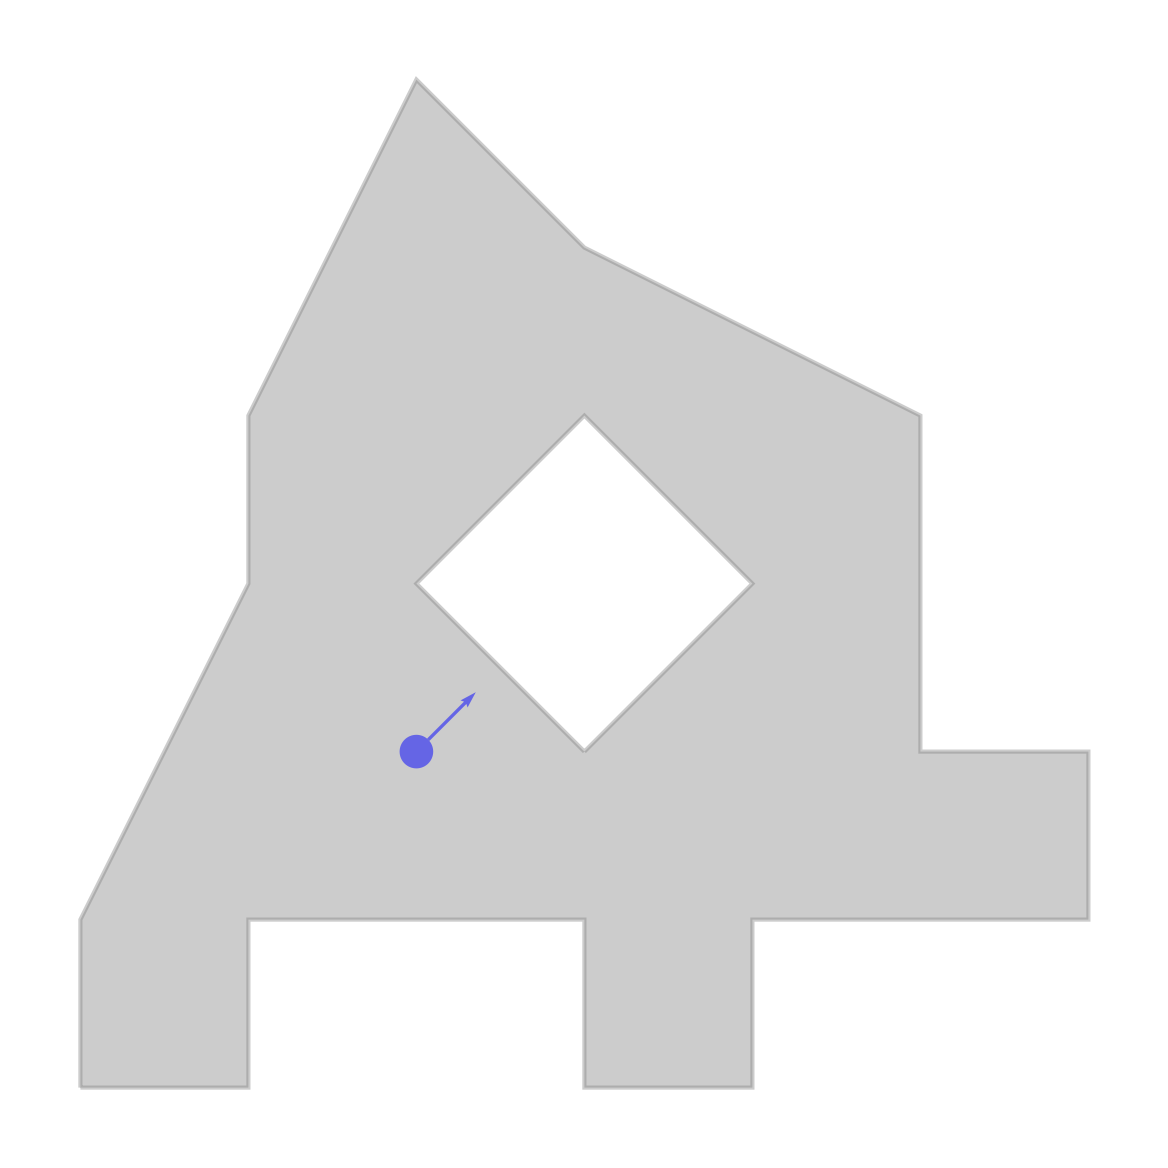

In [6]:
robot = Robot(
    x=100,
    y=100,
    theta=np.pi / 4,
    radius=5,
    max_distance=50,
)
fig, ax = plt.subplots(dpi=300)
ax.set_aspect("equal")
ax.axis("off")
map.visualize(ax=ax)
# plot_line(ray, color='red')
robot.visualize(ax=ax, alpha=0.5)

In [7]:
sample_particles = []
distances = []
for x, y in map.sample_points(n=100, robot_radius=3):
    theta = np.random.uniform(0, 2 * np.pi)
    particle = Robot(x=x, y=y, theta=theta, radius=3)
    sample_particles.append(particle)
    distances.append(particle.measure_distance(map.world, max_distance=100))

real_robot = Robot(x=100, y=100, theta=0.5, radius=3)

TypeError: Robot.__init__() missing 1 required positional argument: 'max_distance'

NameError: name 'real_robot' is not defined

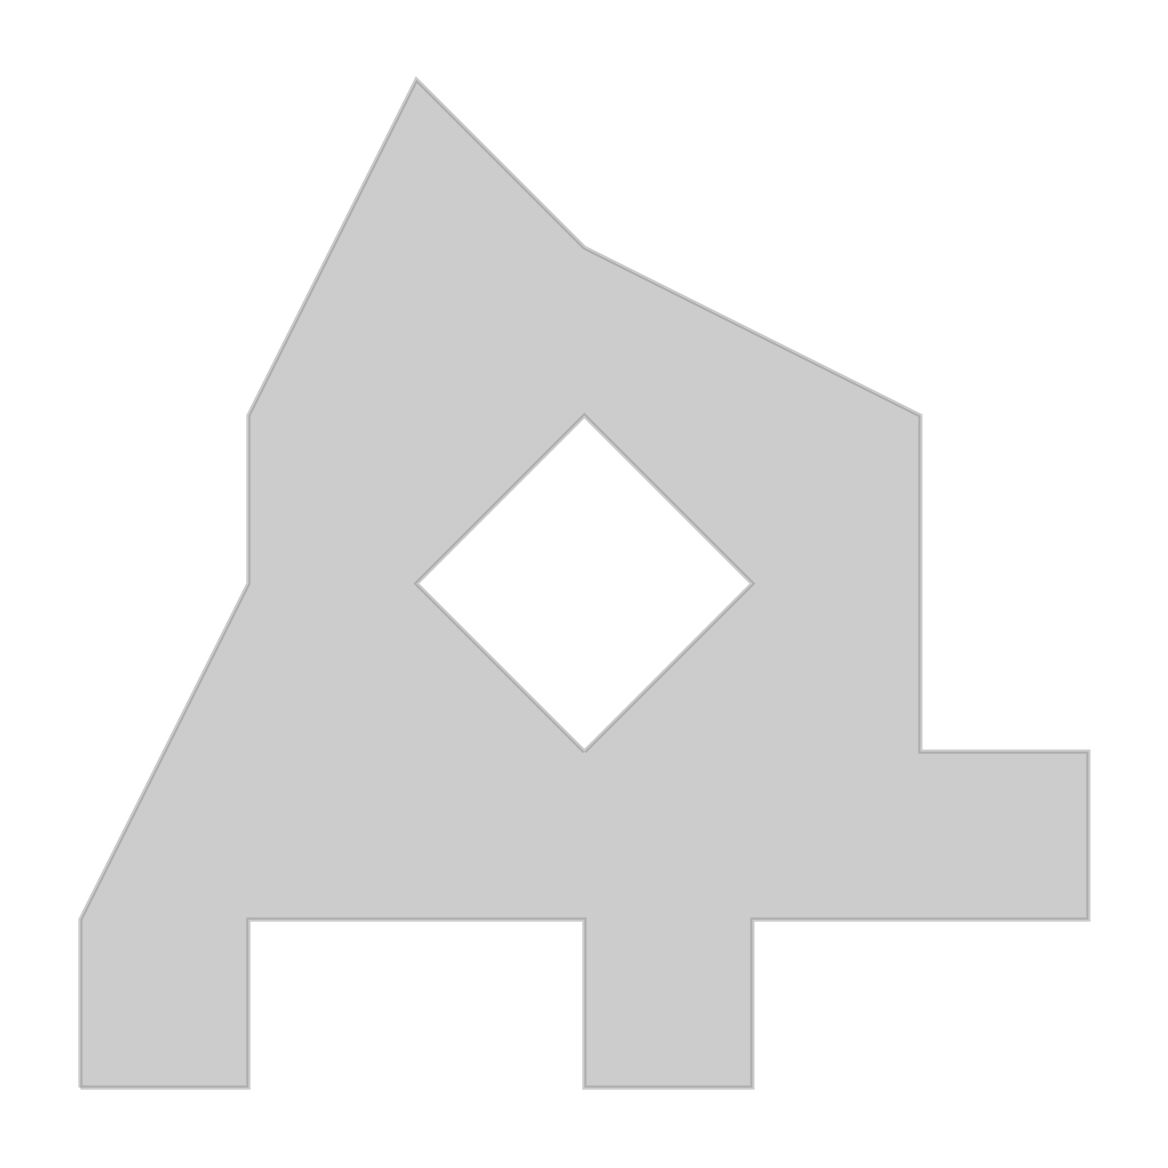

In [8]:
fig, ax = plt.subplots(dpi=300)
ax.set_aspect("equal")
ax.axis("off")


map.visualize(ax=ax)

for particle in sample_particles:
    particle.visualize(ax=ax, alpha=0.5, color="red")
real_robot.visualize(ax=ax, alpha=0.5, color="blue")

dis = []
for i, particle in enumerate(sample_particles):
    distance = distances[i]
    ax.text(
        particle.center_pos[0],
        particle.center_pos[1],
        f"{distance:.2f}",
        fontsize=5,
        ha="center",
        va="center",
        color="black",
    )

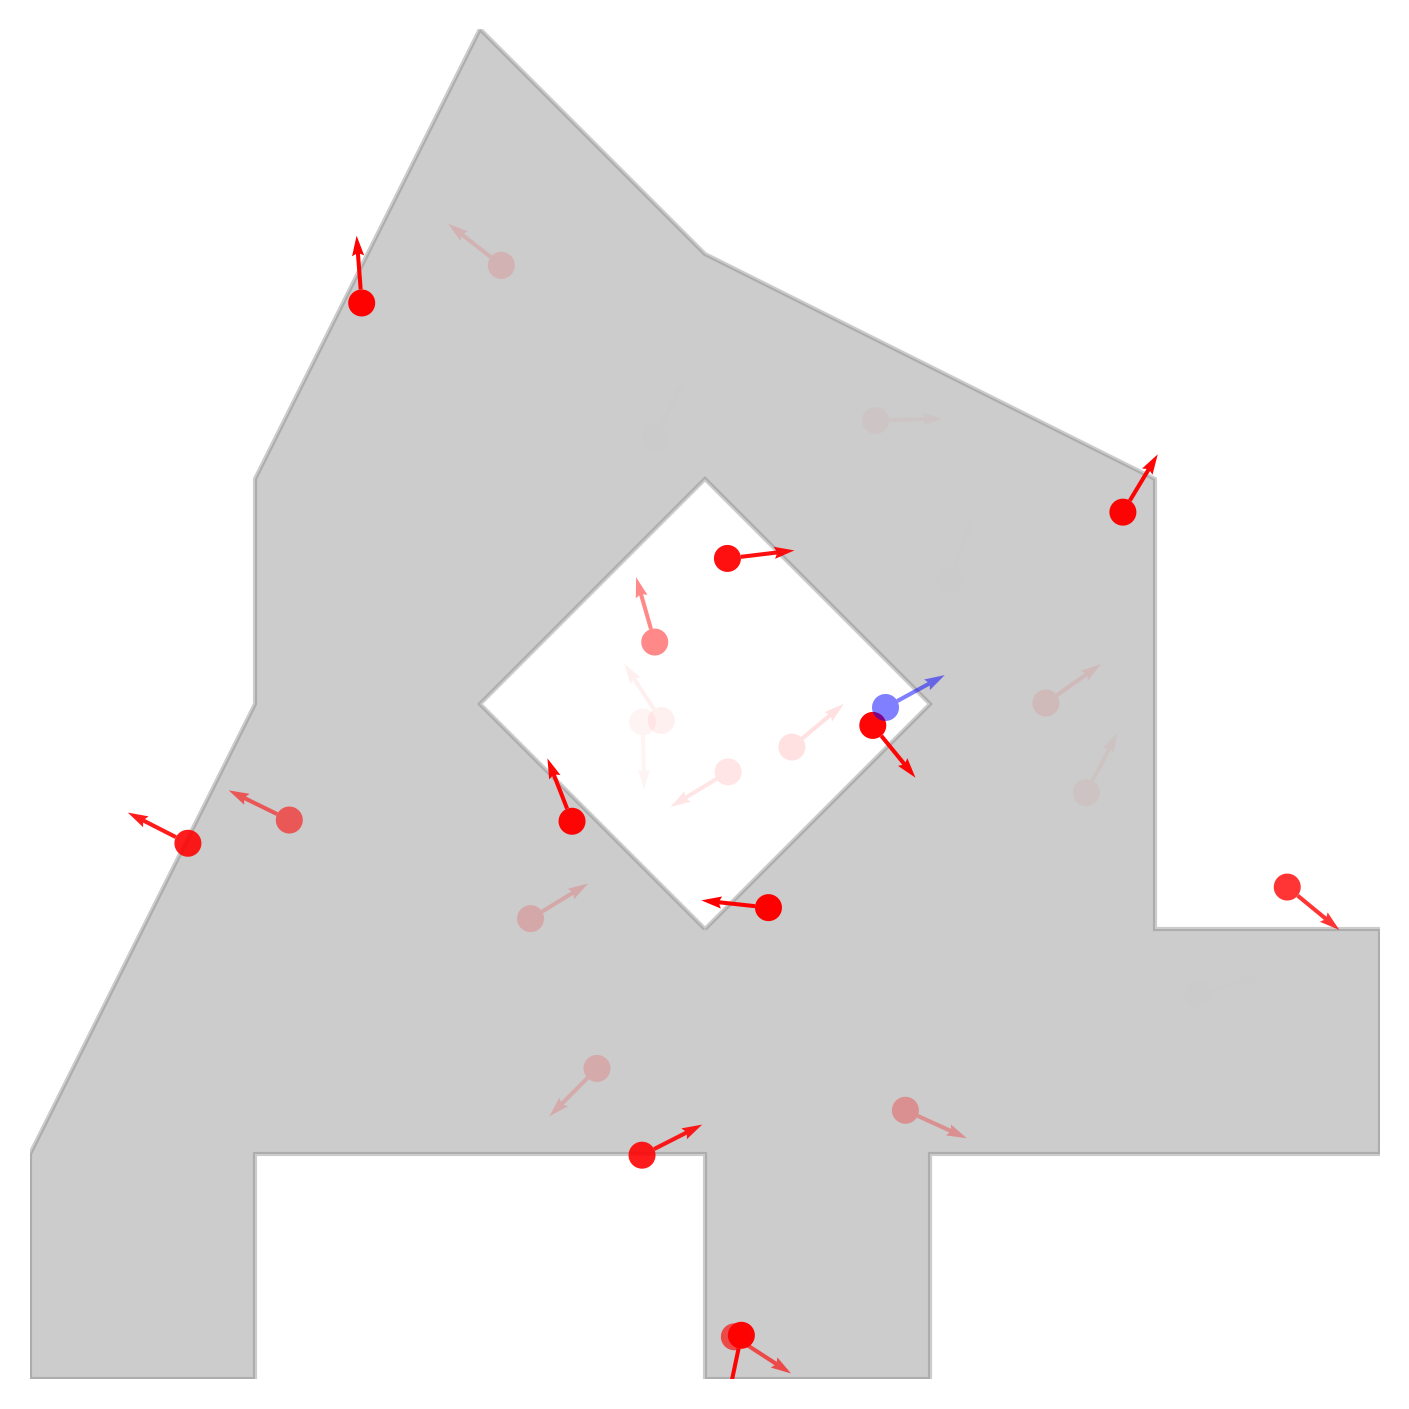

In [ ]:
fig, ax = plt.subplots(dpi=300)
ax.set_aspect("equal")
ax.axis("off")
ax.set_xlim(0, 300)
ax.set_ylim(0, 300)
fig.tight_layout()

# init
map.visualize(ax)  # background map

robot_plots = []
all_artists = []

# sample particles
for particle in sample_particles:
    plot = particle.visualize(ax, color="red")
    robot_plots.append(plot)
    all_artists.extend(plot)

# real robot
real_robot_plot = real_robot.visualize(ax, alpha=0.5, color="blue")
robot_plots.append(real_robot_plot)
all_artists.extend(real_robot_plot)


def update(frame):
    global all_artists

    # TODO: control node to publish move command
    distance = np.random.uniform(0, 1)
    real_robot.move(distance)
    real_distance = real_robot.measure_distance(map.world, max_distance=100)

    distances = []
    for robot in sample_particles:
        robot.move(distance)
        d = robot.measure_distance(map.world, max_distance=100)
        distances.append(d)

    # TODO: update the weights of the particles
    # distances: use to update the weights of the particles\
    error = np.array(distances) - real_distance
    new_factor = np.exp(-abs(error**2 / (2 * 100)))
    for i, robot in enumerate(sample_particles):
        robot.update_factor(new_factor[i])

    # TODO: resample the particles

    # update particle and robot positions
    for i, robot in enumerate(sample_particles):
        robot.update_artist(robot_plots[i])

    real_robot.update_artist(robot_plots[-1])

    return all_artists


ani = animation.FuncAnimation(
    fig,
    update,
    frames=200,
    interval=50,
    blit=True,
)

ani.save("robo_anim_tt.gif", writer=animation.PillowWriter(fps=30))

In [6]:
class MCL:
    def __init__(
        self,
        num_particles: int,
        # map: Map,
        # robot_radius: RealNumber,
        # init_x: RealNumber,
        # init_y: RealNumber,
        # init_theta: RealNumber,
        # max_distance: RealNumber = 100,
    ) -> None:
        self.num_particles = num_particles
        # self.map = map
        # # self.particles = []
        # # TODO: Can be optimized
        # # save all samples position, theta, and weights as np.array
        # # only build the particles when needed
        # # eg. visualization, solve distance...
        # self.particles = ParticleGroup(
        #     positions=np.array(self.map.sample_points(num_particles, robot_radius)),
        #     thetas=np.random.uniform(0, 2 * np.pi, num_particles),
        #     weights=np.ones(num_particles),
        # )

        # set up particles
        # for x, y in self.map.sample_points(  # TODO: Can be optimized
        #     self.num_particles, robot_radius=robot_radius
        # ):
        #     theta = np.random.uniform(0, 2 * np.pi)
        #     particle = SampleParticle(
        #         x=x, y=y, theta=theta, radius=robot_radius, max_distance=max_distance
        #     )
        #     self.particles.append(particle)

        # # set up real robot
        # if self.map.world.contains(Point(init_x, init_y).buffer(robot_radius)):
        #     self.real_robot = Robot(
        #         x=init_x,
        #         y=init_y,
        #         theta=init_theta,
        #         radius=robot_radius,
        #         max_distance=max_distance,
        #     )
        # else:
        #     raise ValueError(
        #         "The initial position of the robot is outside the map boundary."
        #     )

    def update_weights(
        self, real_distance: np.ndarray, distances: np.ndarray, prev_weights: np.ndarray, sigma: RealNumber = 10
    ) -> np.ndarray:
        # real_distance = self.real_robot.measure_distance(self.map.world)
        # distances = self.particles.measure_distance(self.map.world)
        alpha = 0.9
        error = np.array(distances) - real_distance
        new_weights = (1 - alpha)* (np.exp(-abs(error**2 / (2 * sigma**2)))) + alpha * prev_weights

        return new_weights

    def resample(
        self, radius: RealNumber, map: Map, weights: np.ndarray
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Resample the particles by Low Variance Resampling + Random Resampling.

        The algorithm works as follows:
            Low Variance Resampling (LVR, 90% probability):
                1. Normalize the weights so that they sum to 1.
                2. Compute the CDF of the weights.
                3. Sample i/N + s for i in range(N), where s = Uniform(0, 1/N).
                4. Use the CDF to find the indices of the particles to resample.
            Random Resampling (10% probability):
                Resample the particles uniformly in the map.

        Args:
            radius (RealNumber): The radius of the robot.
            map (Map): The map object, used to sample random positions.
            weights (np.ndarray): The weights of the particles.

        Returns:
            selected_idx (np.ndarray): The indices of the particles selected by LVR.
            random_positions (np.ndarray): The positions of the random sample particles.
            random_thetas (np.ndarray): The thetas of the random sample particles.
        """
        # Random Resampling (10% probability)
        random_mask = np.random.uniform(0, 1, self.num_particles) < 0.1
        # random_positions = self.map.sample_points(
        #     n=np.sum(random_mask), robot_radius=self.real_robot.radius
        # )
        random_positions = map.sample_points(n=np.sum(random_mask), robot_radius=radius)
        random_thetas = np.random.uniform(0, 2 * np.pi, np.sum(random_mask))

        # Low Variance Resampling (90% probability)
        # normalize weights
        # normalized_weights = self.particles.weights / np.sum(self.particles.weights)
        normalized_weights = weights / np.sum(weights)
        cdf = np.cumsum(normalized_weights)

        # resample particles
        start_point = np.random.uniform(0, 1 / self.num_particles, 1)
        selected_points = (
            np.arange(self.num_particles) / self.num_particles + start_point
        )

        selected_idx = np.searchsorted(cdf, selected_points, side="right")
        selected_idx = selected_idx[~random_mask]

        return selected_idx, random_positions, random_thetas

In [7]:
class Simulator:
    """
    map, real_robot, particles, mcl solver, control node
    """

    def __init__(
        self,
        map: Map,
        # control_node: ControlNode,
        num_particles: int,
        init_x: RealNumber,
        init_y: RealNumber,
        init_theta: float,
        roboot_radius: RealNumber,
        sensor_max_distance: RealNumber = 100,
        likelyhood_sigma: RealNumber = 10,
        measurement_sigma: RealNumber = 1,
        v_sigma: RealNumber = 0.1,
        w_sigma: RealNumber = 0.1,
        resample_factor: float = 0.5,
        dt=0.1,
    ) -> None:
        self.map = map
        # self.control_node = control_node
        self.num_particles = num_particles
        self.mcl_solver = MCL(num_particles)
        self.likelyhood_sigma = likelyhood_sigma
        self.measurement_sigma = measurement_sigma
        self.v_sigma = v_sigma
        self.w_sigma = w_sigma
        self.resample_threshold = resample_factor
        self.dt = dt
        self.all_artists = []

        # set up real robot
        if self.map.world.contains(Point(init_x, init_y).buffer(roboot_radius)):
            self.real_robot = Robot(
                x=init_x,
                y=init_y,
                theta=init_theta,
                radius=roboot_radius,
                max_distance=sensor_max_distance,
            )
        else:
            raise ValueError(
                "The initial position of the robot is outside the map boundary."
            )
        # init measurement
        self.prev_distance = np.random.normal(
            self.real_robot.measure_distance(self.map.world), self.measurement_sigma
        )

        # set up particles
        self.particles = ParticleGroup(
            positions=np.array(self.map.sample_points(num_particles, roboot_radius)),
            thetas=np.random.uniform(0, 2 * np.pi, num_particles),
            weights=np.ones(num_particles),
            radius=roboot_radius,
            max_distance=sensor_max_distance,
        )

    def get_effective_sample_size(self) -> float:
        """
        Calculate the effective sample size (N_eff) of the particles.

        Definition:
            N_eff = 1 / sum(w_i^2)
            where w_i is the normalized weight of the i-th particle.
        """
        normalized_weights = self.particles.weights / np.sum(self.particles.weights)
        return 1 / np.sum(normalized_weights**2)

    def run_step(self, prev_distance: float) -> float:
        # ACT Model
        # v, w = self.control_node.get_command(prev_distance)
        v = 0
        w = 1
        # move real robot
        self.real_robot.move(v, w, self.dt, self.v_sigma, self.w_sigma)
        # move particles
        self.particles.move(v, w, self.dt, self.v_sigma, self.w_sigma)

        # SEE Model
        # measure distance
        real_distance = self.real_robot.measure_distance(
            self.map.world
        ) + np.random.normal(0, self.measurement_sigma)

        distances = self.particles.measure_distance(self.map.world) + np.random.normal(
            0, self.measurement_sigma, self.num_particles
        )

        # update weights
        weights = self.mcl_solver.update_weights(
            real_distance, distances, prev_weights=self.particles.weights, sigma=self.likelyhood_sigma
        )
        self.particles.update_weights(weights)

        # resample particles
        N_eff = self.get_effective_sample_size()
        if N_eff < self.resample_threshold * self.num_particles:
            # resample particles
            lvr_idx, random_positions, random_thetas = self.mcl_solver.resample(
                radius=self.real_robot.radius,
                map=self.map,
                weights=self.particles.weights,
            )
            self.particles.resample(lvr_idx, random_positions, random_thetas)

        return real_distance

    def main_simulation(self, num_steps: int) -> None:
        # progress bar
        self.progress_bar = tqdm(total=num_steps, desc="Simulating: ", ncols=80)

        def update_progress_bar(n: int, total: int) -> None:
            self.progress_bar.update(1)
            if n == total:
                self.progress_bar.close()
                print("Simulation finished. Saving animation...")

        fig, ax = plt.subplots(dpi=300)
        ax.set_aspect("equal")
        ax.axis("off")
        ax.set_xlim(0, 300)
        ax.set_ylim(0, 300)
        fig.tight_layout()

        # init
        # draw map once
        map.visualize(ax)

        # add real robot's artists: position and direction
        robot_patch, robot_arrow = self.real_robot.visualize(
            ax, alpha=0.5, color="blue"
        )
        self.all_artists.append(robot_patch)
        self.all_artists.append(robot_arrow)
        # add particles' artists: positions and directions
        samples_patch, samples_arrows = self.particles.visualize(ax, color="red")
        self.all_artists.extend(samples_patch)
        self.all_artists.append(samples_arrows)

        self.ani = animation.FuncAnimation(
            fig,
            self.update_frame,
            frames=num_steps,
            interval=50,
            blit=True,
        )

        self.ani.save(
            "robo_anim_0.gif",
            writer=animation.PillowWriter(fps=30),
            progress_callback=update_progress_bar,
        )

    def update_frame(self, frame: int) -> list[Artist]:
        cur_distance = self.run_step(self.prev_distance)

        # update real robot
        self.real_robot.update_artist(self.all_artists[:2])
        # update particles
        self.particles.update_artist(self.all_artists[2:])
        self.prev_distance = cur_distance

        return self.all_artists

Simulating: 100%|█████████████████████████████| 600/600 [01:27<00:00,  6.85it/s]

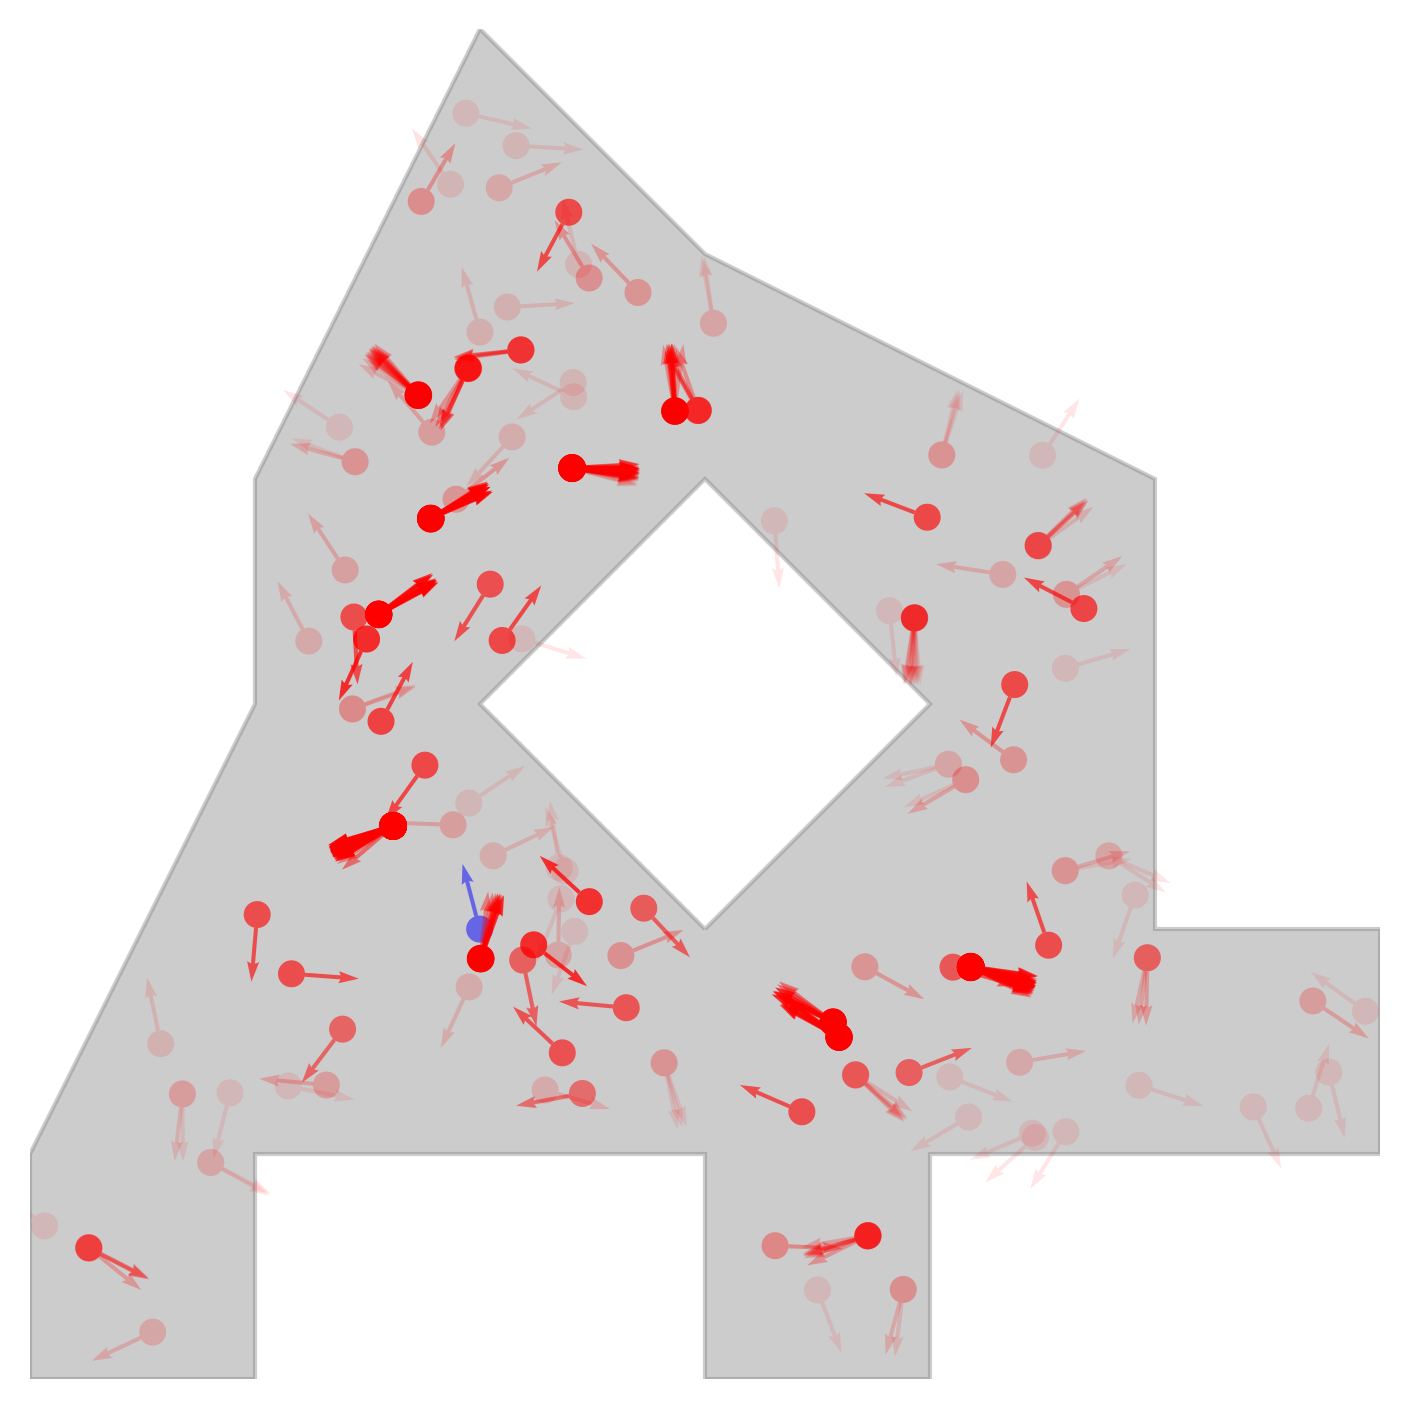

In [8]:
sim = Simulator(
    map=map,
    num_particles=500,
    init_x=100,
    init_y=100,
    init_theta=0.5,
    roboot_radius=3,
    sensor_max_distance=100,
    likelyhood_sigma=10,
    measurement_sigma=1,
    v_sigma=0.1,
    w_sigma=0.1,
    resample_factor=0.5,
    dt=1 / 30,
)

sim.main_simulation(num_steps=600)

MULTIPOLYGON (((0 0.5, -0.0490085701647803 0.5024076366639015, -0.0975451610080641 0.5096073597983848, -0.1451423386272311 0.5215298321338955, -0.1913417161825449 0.5380602337443566, -0.2356983684129988 0.5590393678258225, -0.277785116509801 0.5842651938487273, -0.3171966420818227 0.6134947733186314, -0.3535533905932737 0.6464466094067263, -0.3865052266813685 0.6828033579181773, -0.4157348061512727 0.7222148834901989, -0.4409606321741775 0.764301631587001, -0.4619397662556434 0.8086582838174551, -0.4784701678661044 0.8548576613727688, -0.4903926402016152 0.9024548389919357, -0.4975923633360984 0.9509914298352196, -0.5 1, -0.4975923633360985 1.0490085701647802, -0.4903926402016152 1.0975451610080642, -0.4784701678661045 1.145142338627231, -0.4619397662556434 1.1913417161825448, -0.4409606321741775 1.2356983684129987, -0.4157348061512727 1.277785116509801, -0.3865052266813686 1.3171966420818226, -0.3535533905932738 1.3535533905932737, -0.3171966420818229 1.3865052266813684, -0.2777851165

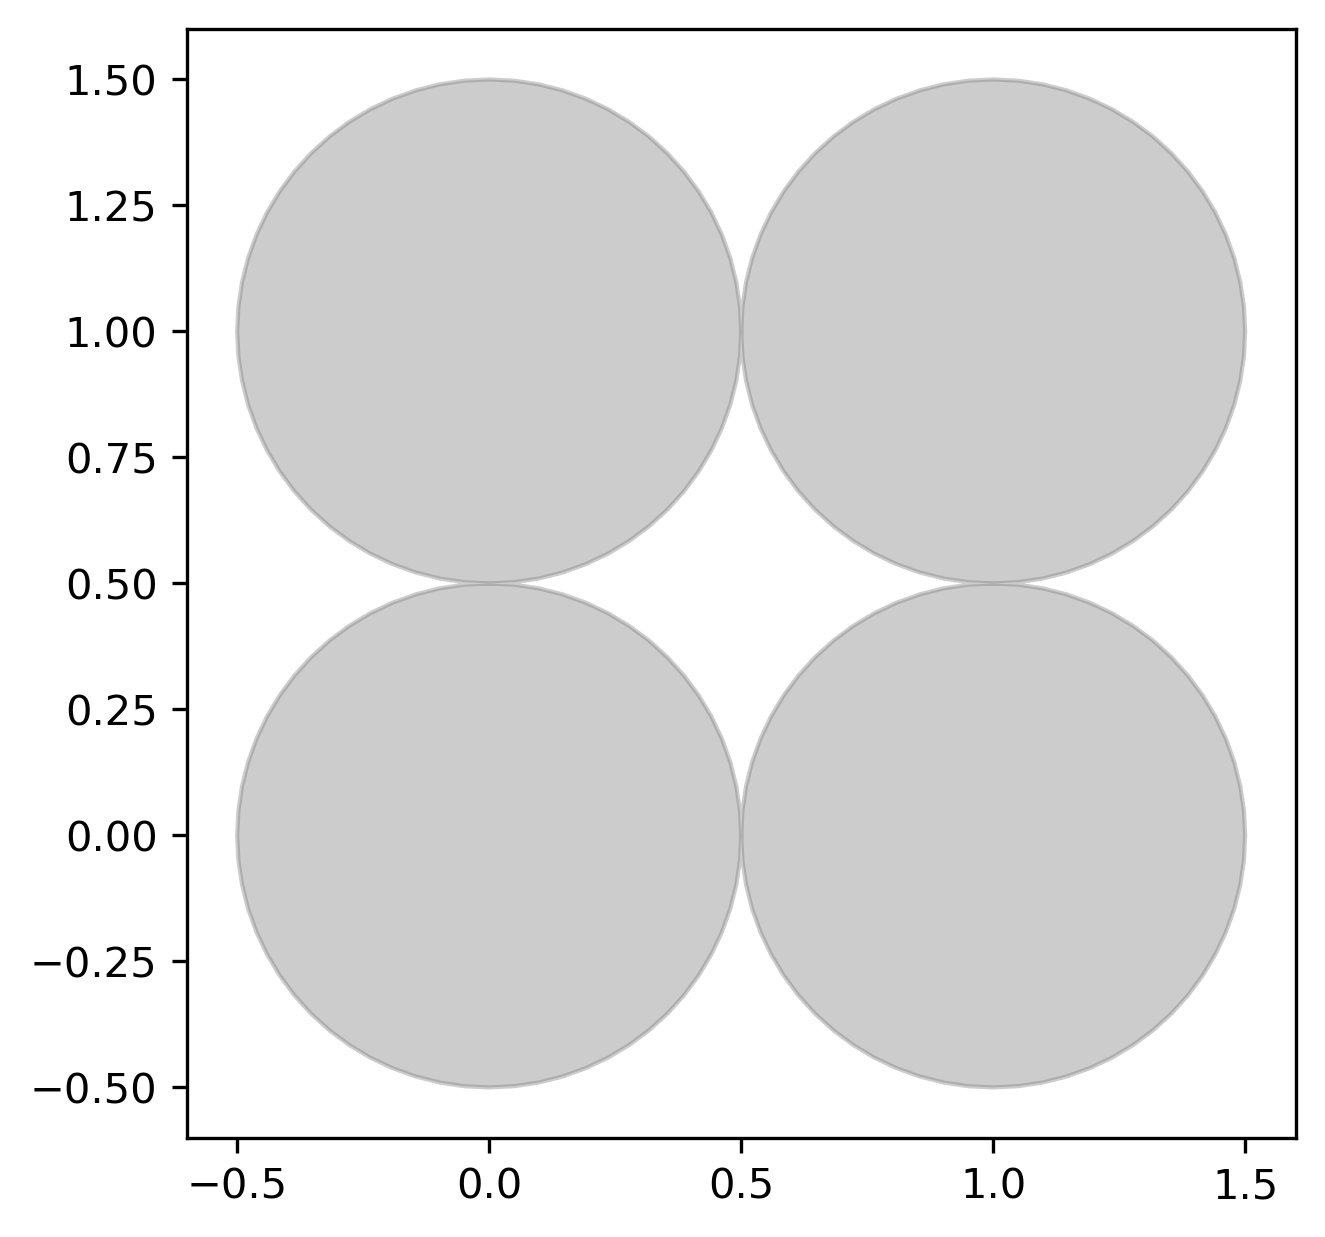

In [ ]:
from shapely import MultiPolygon, MultiPoint

coord = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
m_polygon = MultiPoint(coord).buffer(0.5)  # Create a MultiPolygon from the coordinates
print(m_polygon)

fig, ax = plt.subplots(dpi=300)
ax.set_aspect("equal")
p = plot_polygon(
    m_polygon,
    ax=ax,
    add_points=False,
    color="gray",
    alpha=0.4,
)

type(p)
print(p)

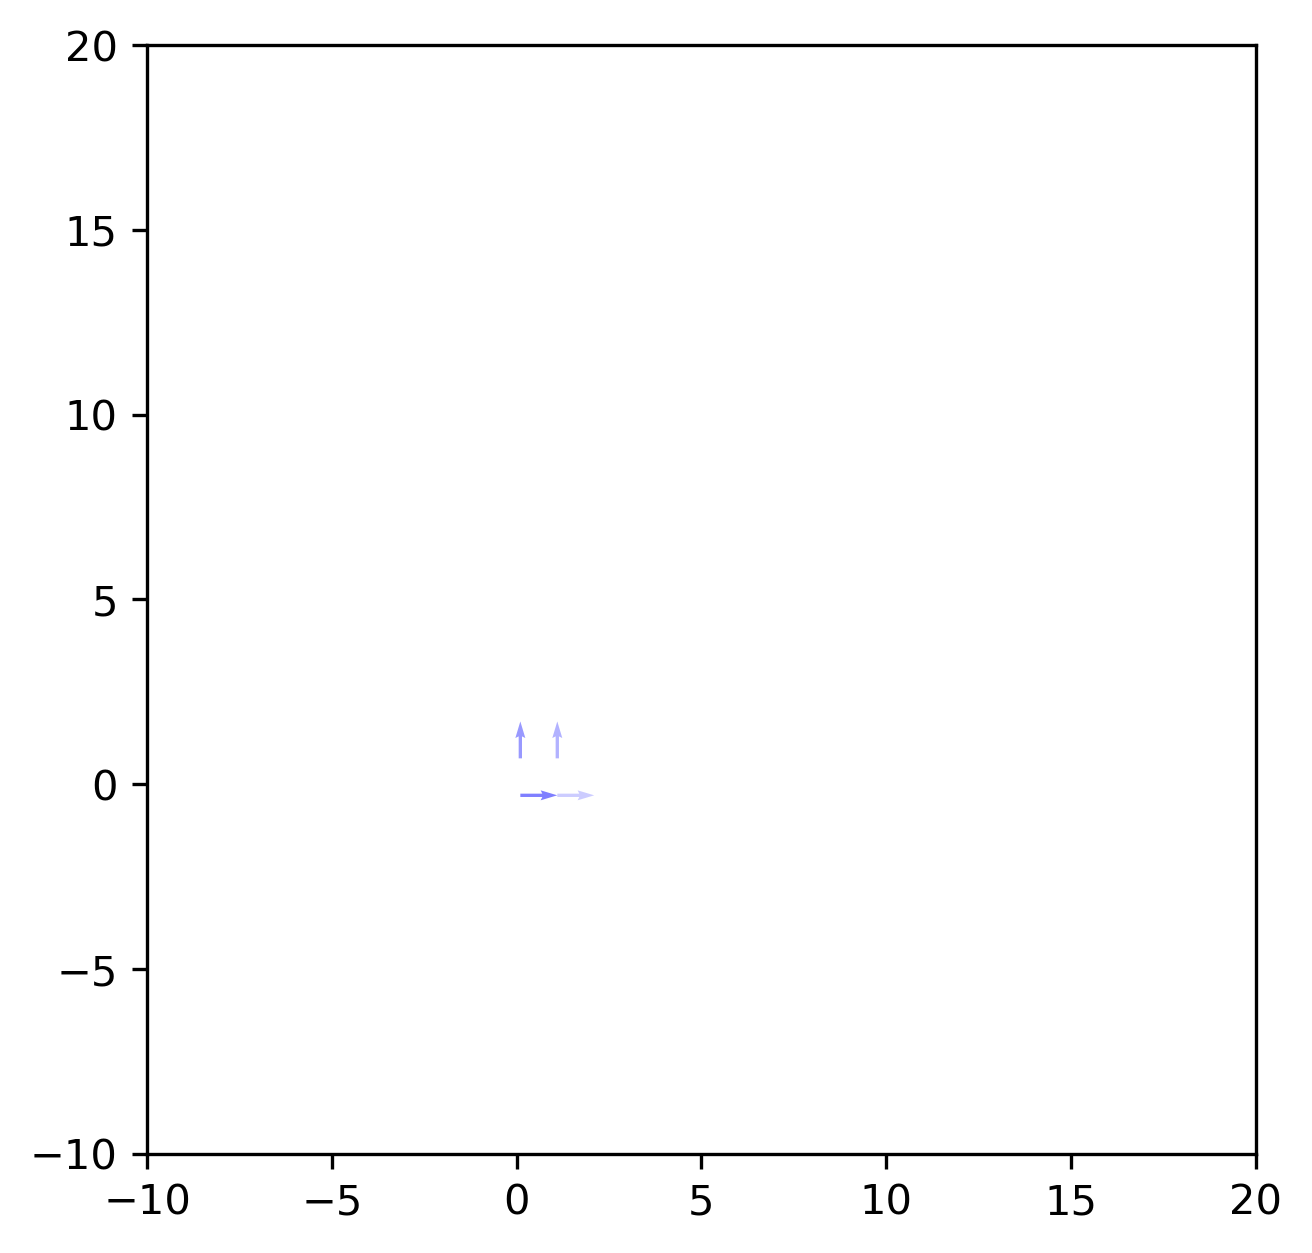

In [30]:
position = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
direction = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
theta = np.array([0, 0, 0, 0])
dx = position[:, 0] + direction[:, 0] * np.cos(theta)
dy = position[:, 1] + direction[:, 1] * np.sin(theta)

fig, ax = plt.subplots(dpi=300)
ax.set_aspect("equal")
ax.set_xlim(-10, 20)
ax.set_ylim(-10, 20)
arrow = ax.quiver(
    position[:, 0],
    position[:, 1],
    dx,
    dy,
    angles="xy",
    scale_units="xy",
    scale=1,
    width=0.003,
    color="blue",
    alpha=np.array([0.5, 0.2, 0.3, 0.4]),
)
x, y = position[:, 0] + 0.1, position[:, 1] - 0.3
arrow.set_offsets(np.column_stack([x, y]))
arrow.set_UVC(dx, dy)
arrow.set_alpha(np.array([0.5, 0.2, 0.3, 0.4]))


In [27]:
particles = ParticleGroup(
    positions=np.array(map.sample_points(100, 3)),
    thetas=np.random.uniform(0, 2 * np.pi, 100),
    weights=np.ones(100),
    radius=3,
    max_distance=100,
)

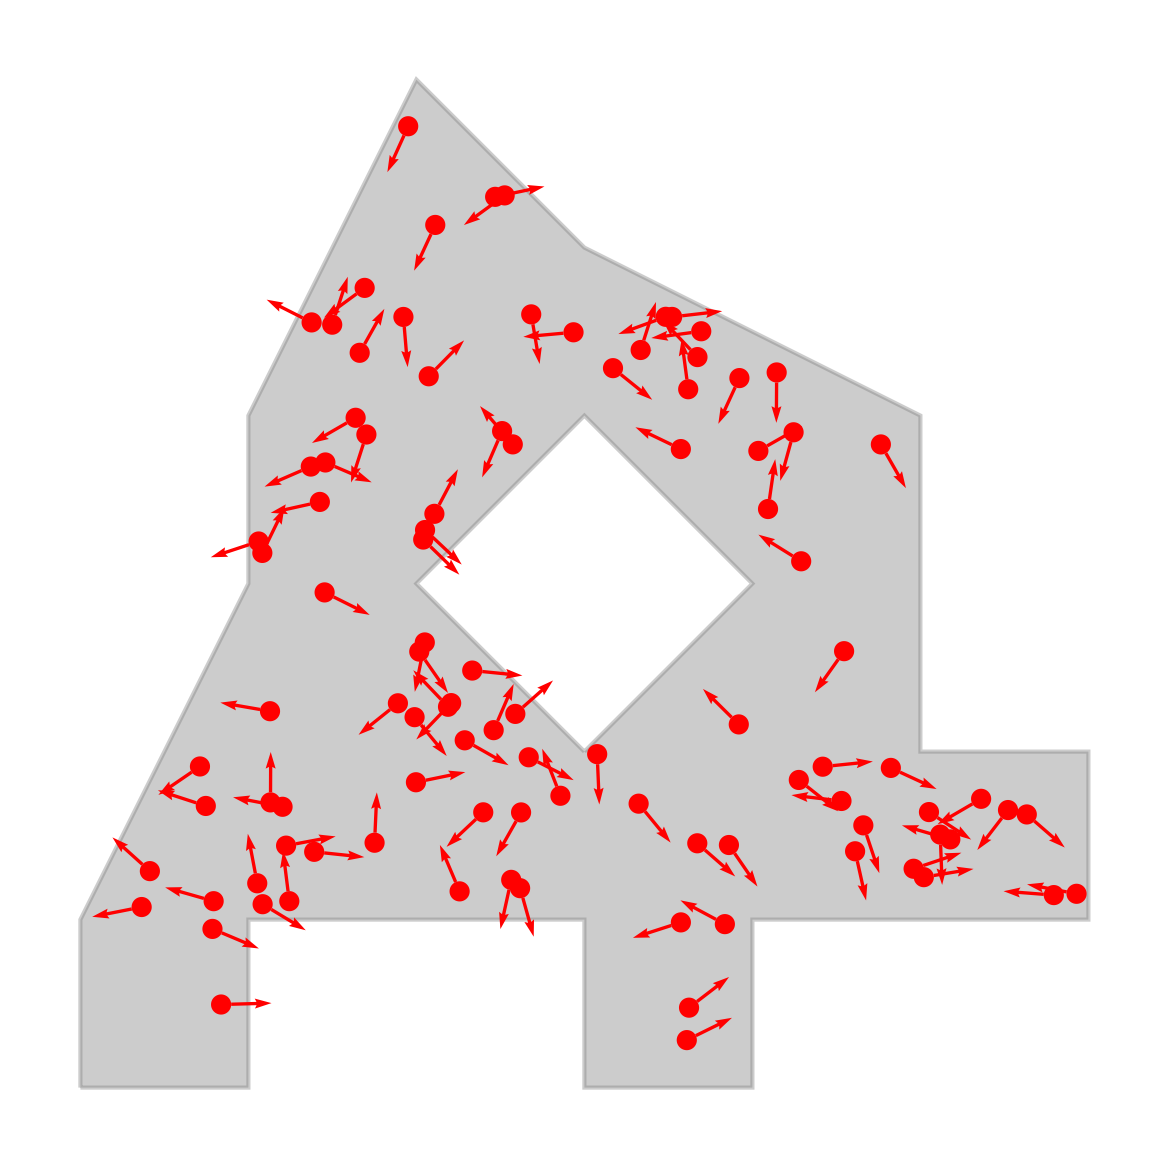

In [29]:
fig, ax = plt.subplots(dpi=300)
ax.set_aspect("equal")
ax.axis("off")
map.visualize(ax=ax)
_ = particles.visualize(ax=ax, color="red")

In [21]:
a = np.array([1, 2, 3])
np.maximum(a, 2)

array([2, 2, 3])